In [ ]:
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import sys

sys.path.append("/content/drive/MyDrive/RL 실습")
sys.path

['',
 '/content',
 '/env/python',
 '/usr/lib/python37.zip',
 '/usr/lib/python3.7',
 '/usr/lib/python3.7/lib-dynload',
 '/usr/local/lib/python3.7/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.7/dist-packages/IPython/extensions',
 '/root/.ipython',
 '/content/drive/MyDrive/RL 실습',
 '/content/drive/MyDrive/RL 실습',
 '/content/drive/MyDrive/RL 실습']

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import drive
from environment import Env

In [ ]:
#그리드 환경의 기본 정보
print(f"가로: {Env().width}")
print(f"세로: {Env().height}")

가로: 5
세로: 5


In [ ]:
#환경의 상태들
Env().get_all_states()[:5]

[[0, 0], [0, 1], [0, 2], [0, 3], [0, 4]]

In [ ]:
#환경의 액션
Env().possible_actions

[0, 1, 2, 3]

In [ ]:
#행동 후 상태 가져오기
Env().state_after_action([1, 2], 2)

[1, 1]

In [ ]:
#환경에서 보상 가져오기 
print("보상 1 : {}".format(Env().get_reward([2, 1], 3)))
print("보상 2 : {}".format(Env().get_reward([2, 0], 3)))

보상 1 : 1
보상 2 : -1


Value Iteration agent

In [ ]:
class ValueIteration:
  def __init__(self, env):
    #환경 객체 선언
    self.env = env
    #가치함수 2차원 리스트 초기화
    self.value_table = np.zeros((env.width, env.height)).tolist()
    #할인율
    self.discount_factor = 0.9
  
  def value_evaluation(self):
    #V_net 초기화
    next_value_table = np.zeros((self.env.width, self.env.height)).tolist()
    
    #모든 상태에 대해서 벨만 최적 방정식 계산(인덱스 순의 상태로 업데이트)
    for state in self.env.get_all_states():
      #종결 상태 가치 = 0
      if state == [2, 2]:
        next_value_table[state[0]][state[1]] = 0
        continue

      #벨만 최적 방정식 (v = max(q))
      q_value_list = []
      for action in self.env.possible_actions:
        q_value = self.get_q_value(state, action)
        q_value_list.append(q_value)
      next_value_table[state[0]][state[1]] = max(q_value_list)
    
    new_value = np.array(next_value_table).flatten()
    old_value = np.array(self.value_table).flatten()
    value_err = np.linalg.norm(new_value - old_value)

    self.value_table = next_value_table
    return value_err

  #하나의 (상태, 액션)에 대한 q값 반환
  def get_q_value(self, state, action):
    next_state = self.env.state_after_action(state, action)
    reward = self.env.get_reward(state, action)
    next_value = self.get_value(next_state)
    q_value = reward + self.discount_factor*next_value #트랜지션 = 1
    return q_value

  #상태에 따른 가치 반환
  def get_value(self, state):
    return self.value_table[state[0]][state[1]]
  
  #특정 상태에서 정책에 따라 그리디 행동 반환
  def get_action(self, state):
    if state == [2, 2]:
      return []
    
    #모든 행동에 대해 q값 계산
    q_value_list = []
    for action in self.env.possible_actions:
      q_value = self.get_q_value(state, action)
      q_value_list.append(q_value)
    
    #최대 q값을 가진 행동 반환
    max_idx_list = np.argwhere(q_value_list == np.amax(q_value_list))
    action_list = max_idx_list.flatten().tolist()
    return np.random.choice(action_list)

In [ ]:
#그리드 Show 함수
def show(agent_state):

  dis = dict()
  state_len = len(Env().get_all_states())

  terminal_list = [[0,0], [2,2]]
  terminal_idxes = []

  state_idx = Env().get_all_states().index(agent_state)

  for state in range(state_len):
    dis[state] = "o"

  for terminal in terminal_list:
    idx = Env().get_all_states().index(terminal)
    terminal_idxes.append(idx)

  for terminal_idx in terminal_idxes:
    dis[terminal_idx] = "T"

  if state_idx in terminal_idxes:
    dis[state_idx] = "x" 
  else:
    dis[state_idx] = "x" 
  
  grid = ""
  for i in range(state_len):
    if (i+1) % Env().width != 0:
      grid += " " + dis[i]
    else:
      grid += " " + dis[i] + "\n"
  
  return print(grid)

Value Iteration

In [ ]:
class Iterator:
  def __init__(self):
    self.env = Env()
    self.agent = ValueIteration(self.env)
  
  def iterate(self, error_tol=1e-5):
    value_tables = []
    value_errs = []
    steps = 0

    while True: 
      steps += 1
      value_err = self.agent.value_evaluation()
      value_tables.append(self.agent.value_table)
      value_errs.append(value_err)

      if value_err <= error_tol:
        print("err: {}".format(value_err))
        print("steps: {}".format(steps))
        break
    return value_tables, value_errs
  
  def run(self):
    state = [0, 0]
    t = 0
    while True:
      t += 1
      action = self.agent.get_action(state)
      next_state = self.env.state_after_action(state, action)
      print("{} iteration".format(t))
      show(next_state)
      state = next_state

      if state == [2, 2]:
        break

In [ ]:
iterator = Iterator()

In [ ]:
value_tables, value_errs = iterator.iterate()

err: 0.0
steps: 7


In [ ]:
#행동 관찰
iterator.run()

1 iteration
 T x o o o
 o o o o o
 o o T o o
 o o o o o
 o o o o o

2 iteration
 T o x o o
 o o o o o
 o o T o o
 o o o o o
 o o o o o

3 iteration
 T o o x o
 o o o o o
 o o T o o
 o o o o o
 o o o o o

4 iteration
 T o o o o
 o o o x o
 o o T o o
 o o o o o
 o o o o o

5 iteration
 T o o o o
 o o o o o
 o o T x o
 o o o o o
 o o o o o

6 iteration
 T o o o o
 o o o o o
 o o x o o
 o o o o o
 o o o o o



In [ ]:
#가치 테이블 시각화
def visualizer(data):
  data = np.array(data)
  len = data.shape[0]
  plt.figure(figsize=(20, 12))

  for i in range(len):
    plt.subplot(4, len-4, i+1)
    sns.heatmap(value_tables[i], annot=True, 
                cmap="PuBu", vmin=0, vmax=1, cbar=False)
    
    ax = plt.gca()
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)

    plt.title("{} update".format(i+1))
  
  plt.show()

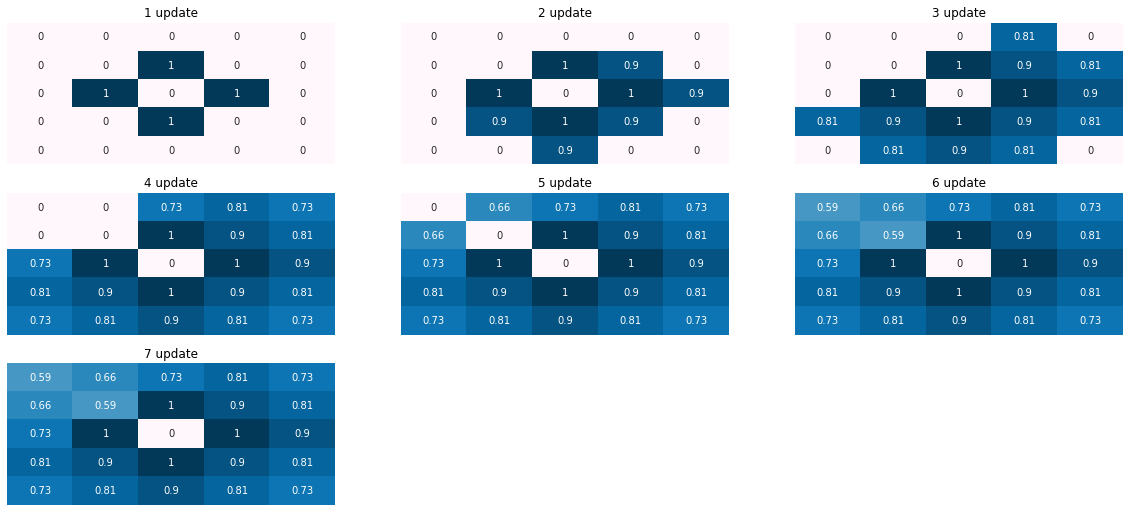

In [ ]:
#가치함수 변화
visualizer(value_tables)